In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bracu-project/bracu/val/Tuberculosis/test_0_5161.jpeg
/kaggle/input/bracu-project/bracu/val/Tuberculosis/test_0_4769.jpeg
/kaggle/input/bracu-project/bracu/val/Tuberculosis/test_0_1443.jpeg
/kaggle/input/bracu-project/bracu/val/Tuberculosis/test_0_5261.jpeg
/kaggle/input/bracu-project/bracu/val/Tuberculosis/Tuberculosis-392.jpg
/kaggle/input/bracu-project/bracu/val/Tuberculosis/test_0_5266.jpeg
/kaggle/input/bracu-project/bracu/val/Tuberculosis/test_0_2134.jpeg
/kaggle/input/bracu-project/bracu/val/Tuberculosis/test_0_991.jpeg
/kaggle/input/bracu-project/bracu/val/Tuberculosis/test_0_1548.jpeg
/kaggle/input/bracu-project/bracu/val/Tuberculosis/Tuberculosis-176.jpg
/kaggle/input/bracu-project/bracu/val/Tuberculosis/test_0_4571.jpeg
/kaggle/input/bracu-project/bracu/val/Tuberculosis/test_0_4093.jpeg
/kaggle/input/bracu-project/bracu/val/Tuberculosis/test_0_5391.jpeg
/kaggle/input/bracu-project/bracu/val/Tuberculosis/test_0_1970.jpeg
/kaggle/input/bracu-project/bracu/val/Tub

In [2]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from sklearn.model_selection import train_test_split
from datasets import load_metric
from sklearn.metrics import accuracy_score
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
!pip install -U accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 2.5 MB/s eta 0:00:00a 0:00:01m
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.33.0
    Uninstalling accelerate-0.33.0:
      Successfully uninstalled accelerate-0.33.0


In [3]:
pip install -U accelerate

Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install timm

In [5]:
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 801.1 kB/s eta 0:00:000:00:01


In [34]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from timm import create_model
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import os

In [36]:
class LungCancerDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_paths = []
        self.labels = []
        self.class_names = sorted(os.listdir(img_dir))

        for label, class_name in enumerate(self.class_names):
            class_folder = os.path.join(img_dir, class_name)
            for img_name in os.listdir(class_folder):
                self.img_paths.append(os.path.join(class_folder, img_name))
                self.labels.append(label)
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [37]:
batch_size = 16
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [38]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [39]:
train_dataset = LungCancerDataset('/kaggle/input/bracu-project/bracu/train', transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)

val_dataset = LungCancerDataset('/kaggle/input/bracu-project/bracu/val', transform=transform)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size)

test_dataset = LungCancerDataset('/kaggle/input/bracu-project/bracu/test', transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

In [40]:
model = create_model('vit_base_patch16_224', pretrained=True, num_classes=len(train_dataset.class_names))
model = model.to(device)

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

In [43]:
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')

Epoch 1/5: 100%|██████████| 380/380 [04:42<00:00,  1.34it/s]


Epoch [1/5], Loss: 0.2514, Accuracy: 98.24%


Epoch 2/5: 100%|██████████| 380/380 [04:38<00:00,  1.36it/s]


Epoch [2/5], Loss: 2.1561, Accuracy: 94.28%


Epoch 3/5: 100%|██████████| 380/380 [04:36<00:00,  1.37it/s]


Epoch [3/5], Loss: 4.3761, Accuracy: 92.35%


Epoch 4/5: 100%|██████████| 380/380 [04:34<00:00,  1.38it/s]


Epoch [4/5], Loss: 2.6746, Accuracy: 94.30%


Epoch 5/5: 100%|██████████| 380/380 [04:40<00:00,  1.35it/s]

Epoch [5/5], Loss: 2.2015, Accuracy: 94.78%


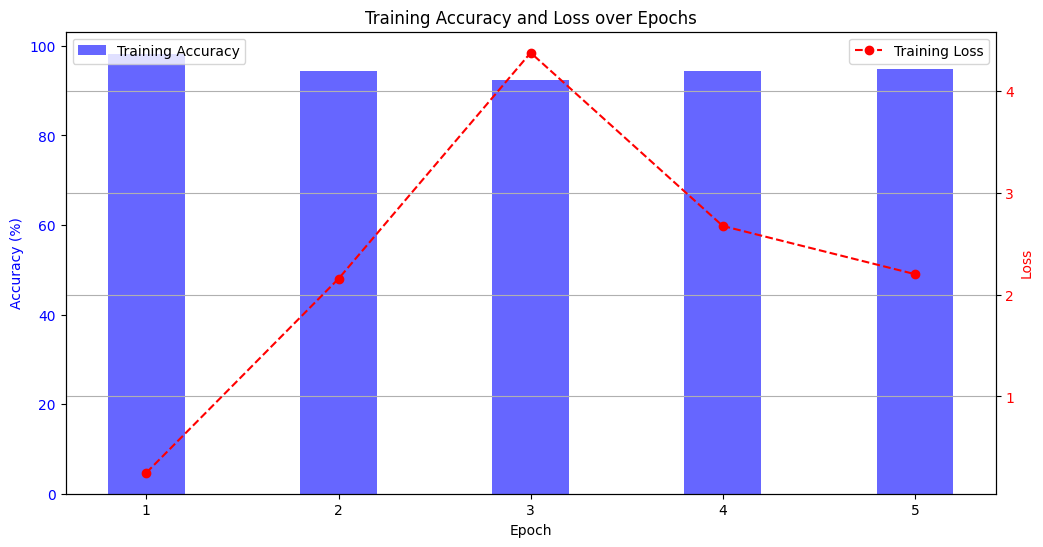

In [47]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Training Accuracy', color='blue', marker='o')
plt.plot(train_losses, label='Training Loss', color='red', marker='x')
plt.title('Training Accuracy and Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

In [48]:
model = create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=len(train_dataset.class_names))
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

# Training loop
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Epoch 1/5: 100%|██████████| 380/380 [02:37<00:00,  2.41it/s]


Epoch [1/5], Loss: 0.2754, Accuracy: 97.61%


Epoch 2/5: 100%|██████████| 380/380 [02:35<00:00,  2.44it/s]


Epoch [2/5], Loss: 0.7774, Accuracy: 94.76%


Epoch 3/5: 100%|██████████| 380/380 [02:33<00:00,  2.47it/s]


Epoch [3/5], Loss: 1.5697, Accuracy: 92.62%


Epoch 4/5: 100%|██████████| 380/380 [02:33<00:00,  2.47it/s]


Epoch [4/5], Loss: 1.4069, Accuracy: 90.59%


Epoch 5/5: 100%|██████████| 380/380 [02:34<00:00,  2.46it/s]

Epoch [5/5], Loss: 1.0412, Accuracy: 92.15%
